# Hipotesis pruebas y pruebas A/B


 En este proyecto pondremos en practica lo aprendido con respecto a hipotesis y pruebas A/B

## Importacion, limpieza y correccion de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
hipotesis = pd.read_csv('hypotheses_us-1.csv',sep=';')
ordenes = pd.read_csv('orders_us-1.csv')
visitas = pd.read_csv('visits_us-1.csv')

print(hipotesis.info())
print(hipotesis.head(9))
print()
print(ordenes.info())
print(ordenes.head())
print()
print(visitas.info())
print(visitas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None
                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   
5  Add a customer review page. This will increase...      3       2   
6  Show banners with current offers and sales on ...      5    

Convertir a tipo fecha

In [3]:
ordenes['date'] = pd.to_datetime(ordenes['date'])
visitas['date'] = pd.to_datetime(visitas['date'])

print(ordenes.info())
print(visitas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


## Parte 1. Priorizacion de hipotesis

### Framework ICE

In [4]:
hipotesis['ICE'] = (hipotesis['Impact'] * hipotesis['Confidence']) * hipotesis['Effort']
print(hipotesis['ICE'].sort_values(ascending=False))

0    480
8    405
7    280
1    200
3     72
6     72
2     63
5     12
4      1
Name: ICE, dtype: int64


In [5]:
hipotesis['ICE_2'] = (hipotesis['Impact'] * hipotesis['Confidence']) / hipotesis['Effort']
print(hipotesis['ICE_2'].sort_values(ascending=False))

8    16.200000
0    13.333333
7    11.200000
6     8.000000
2     7.000000
1     2.000000
5     1.333333
3     1.125000
4     1.000000
Name: ICE_2, dtype: float64


Por la metodologia ICE la hipotesis con mas prioridad es la hipotesis 8, es decir, la que de una promocion de descuentos

### Framework RICE

In [6]:
hipotesis['RICE'] = (hipotesis['Impact'] * hipotesis['Confidence'] * hipotesis['Reach'])/ hipotesis['Effort']
print(hipotesis['RICE'].sort_values(ascending=False))

7    112.0
2     56.0
0     40.0
6     40.0
8     16.2
3      9.0
1      4.0
5      4.0
4      3.0
Name: RICE, dtype: float64


Por el framework RICE la hipotesis con prioridad es la hipotesis 7, es decir, la de agragar suscriciones a todas las paginas principales

### Conclusiones de la parte 1

La razón por la que hubieron algunos cambios radicales en las posiciones es lo que considera cada framework. Cuando realizamos RICE el alcance toma importancia, por lo que si es un factor importante para lo que se busca es mejor usar RICE para tomar una mejor decision. Si lo que buscamos es certeza por sobre todo, puede que sea mas conveniente usar ICE.

## Parte 2. Analisis A/B

### Revision de distribucion de los datos

In [7]:
#Division de grupos
grupoA = ordenes[ordenes['group'] == 'A']
grupoB = ordenes[ordenes['group'] == 'B']

grupoA_cum = np.cumsum(grupoA['revenue'])
grupoB_cum = np.cumsum(grupoB['revenue'])

print(grupoA_cum)
print(grupoB_cum)

2          10.2
7          30.3
8         246.2
10        311.9
12        427.3
         ...   
1187    64328.3
1188    64334.0
1193    64384.1
1194    64549.4
1195    64554.9
Name: revenue, Length: 557, dtype: float64
0          30.4
1          45.6
3         200.7
4         241.2
5         276.2
         ...   
1189    89228.7
1190    89364.0
1191    89619.7
1192    89720.5
1196    92840.6
Name: revenue, Length: 640, dtype: float64


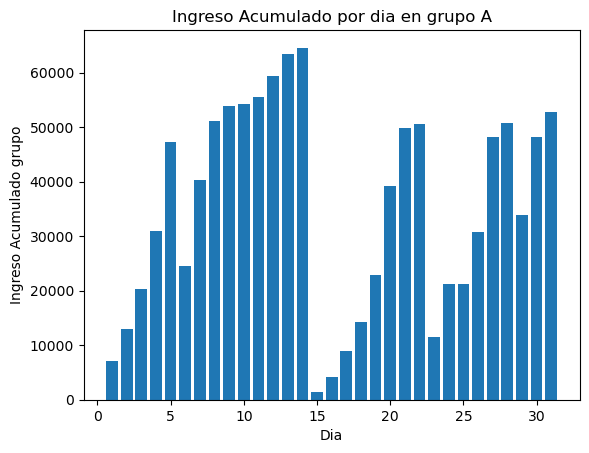

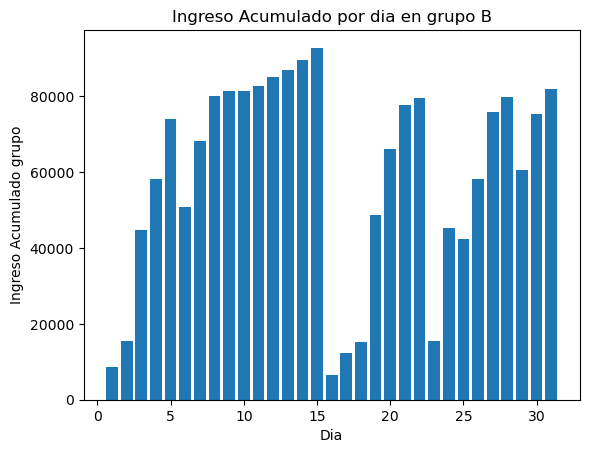

In [8]:
plt.bar(x=grupoA['date'].dt.day, height=grupoA_cum)
plt.xlabel("Dia")
plt.ylabel("Ingreso Acumulado grupo")
plt.title("Ingreso Acumulado por dia en grupo A")
plt.show()
plt.bar(x=grupoB['date'].dt.day, height=grupoB_cum)
plt.xlabel("Dia")
plt.ylabel("Ingreso Acumulado grupo")
plt.title("Ingreso Acumulado por dia en grupo B")
plt.show()

En los grupos A y B se puede notar que el dia con mas ingreso es el dia 14 y 15 y el periodo de una semana previa a esa fecha hay bastantes ingresos

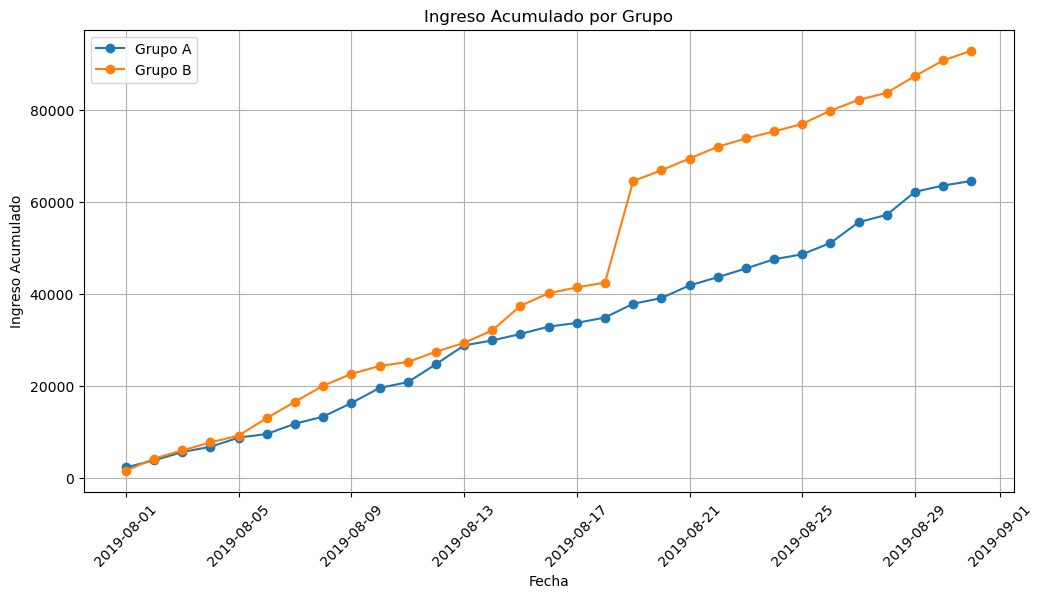

In [9]:
cumulative_revenue = ordenes.groupby(["date", "group"])["revenue"].sum().groupby(level=1).cumsum().reset_index()

# Graficar el ingreso acumulado por grupo
plt.figure(figsize=(12, 6))
for group in cumulative_revenue["group"].unique():
    subset = cumulative_revenue[cumulative_revenue["group"] == group]
    plt.plot(subset["date"], subset["revenue"], marker="o", label=f"Grupo {group}")

plt.xlabel("Fecha")
plt.ylabel("Ingreso Acumulado")
plt.title("Ingreso Acumulado por Grupo")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Podemos notar que ambos grupos

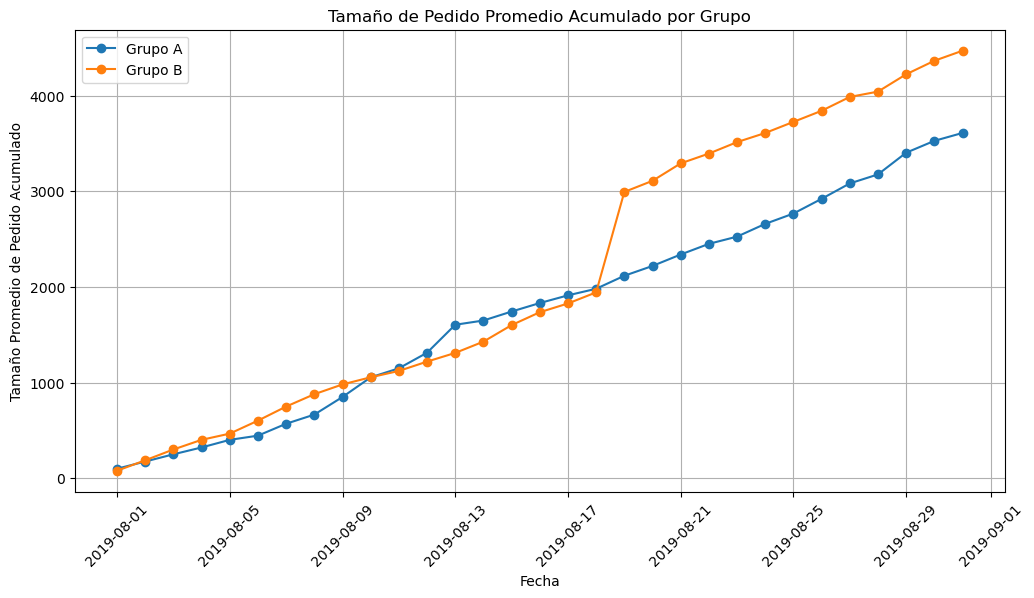

In [10]:
# Calcular el tamaño promedio del pedido acumulado por grupo
orders_per_day = ordenes.groupby(["date", "group"]).agg({"revenue": "sum", "transactionId": "count"}).reset_index()
orders_per_day["avg_order_size"] = orders_per_day["revenue"] / orders_per_day["transactionId"]

# Calcular el promedio acumulado
orders_per_day["cumulative_avg_order_size"] = orders_per_day.groupby("group")["avg_order_size"].cumsum()

# Graficar el tamaño de pedido promedio acumulado por grupo
plt.figure(figsize=(12, 6))
for group in orders_per_day["group"].unique():
    subset = orders_per_day[orders_per_day["group"] == group]
    plt.plot(subset["date"], subset["cumulative_avg_order_size"], marker="o", label=f"Grupo {group}")

plt.xlabel("Fecha")
plt.ylabel("Tamaño Promedio de Pedido Acumulado")
plt.title("Tamaño de Pedido Promedio Acumulado por Grupo")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

En ambas graficas podemos notar un ingreso y tamaño de pedidos bastante constante e igua en ambos grupos, hasta e 19 de agosto donde existe una orden grande

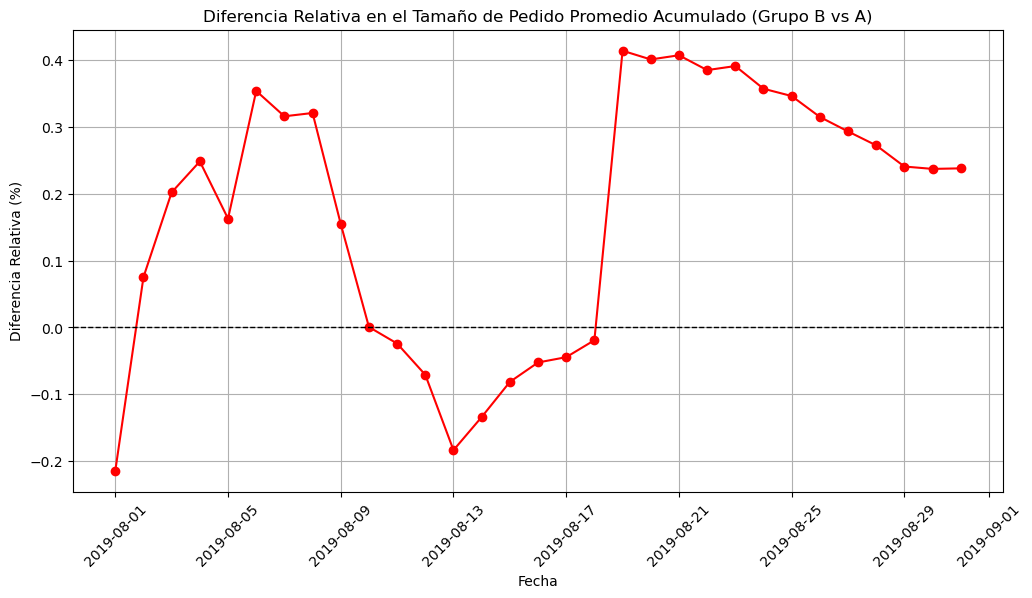

In [11]:
# Calcular el tamaño de pedido promedio acumulado por grupo
cumulative_avg_order_size = orders_per_day.pivot(index="date", columns="group", values="cumulative_avg_order_size")

# Calcular la diferencia relativa entre el grupo B y A
cumulative_avg_order_size["relative_difference"] = (cumulative_avg_order_size["B"] / cumulative_avg_order_size["A"]) - 1

# Graficar la diferencia relativa
plt.figure(figsize=(12, 6))
plt.plot(cumulative_avg_order_size.index, cumulative_avg_order_size["relative_difference"], marker="o", linestyle="-", color="r")

plt.axhline(y=0, color="black", linestyle="--", linewidth=1)  # Línea de referencia en 0%
plt.xlabel("Fecha")
plt.ylabel("Diferencia Relativa (%)")
plt.title("Diferencia Relativa en el Tamaño de Pedido Promedio Acumulado (Grupo B vs A)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Aqui podemos notar que la mayoria del tiempo el grupo B tiene un tamaño de pedido mayor que los del grupo a acentuando esta diferencia el 19 de agosto, permaneciendo casi constante hasta final de mes

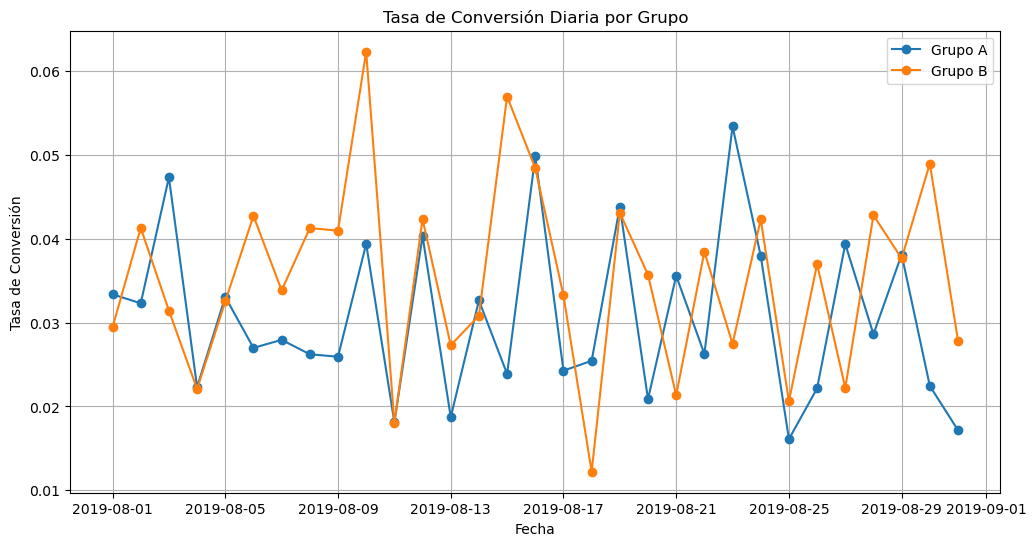

In [12]:
# Contar el número de pedidos por día y grupo
orders_per_day = ordenes.groupby(["date", "group"]).agg({"transactionId": "count"}).reset_index()
orders_per_day.rename(columns={"transactionId": "orders"}, inplace=True)

# Unir con el dataset de visitas para calcular la tasa de conversión
conversion_df = orders_per_day.merge(visitas, on=["date", "group"])
conversion_df["conversion_rate"] = conversion_df["orders"] / conversion_df["visits"]

# Graficar la tasa de conversión diaria por grupo
plt.figure(figsize=(12, 6))
for group in conversion_df["group"].unique():
    subset = conversion_df[conversion_df["group"] == group]
    plt.plot(subset["date"], subset["conversion_rate"], marker="o", linestyle="-", label=f"Grupo {group}")

plt.xlabel("Fecha")
plt.ylabel("Tasa de Conversión")
plt.title("Tasa de Conversión Diaria por Grupo")
plt.legend()

plt.grid(True)
plt.show()

Esta grafica nos permite ver que la conversion en el grupo A es mas consistente a traves del tiempo que la del gruppo B pero las de este son mayores

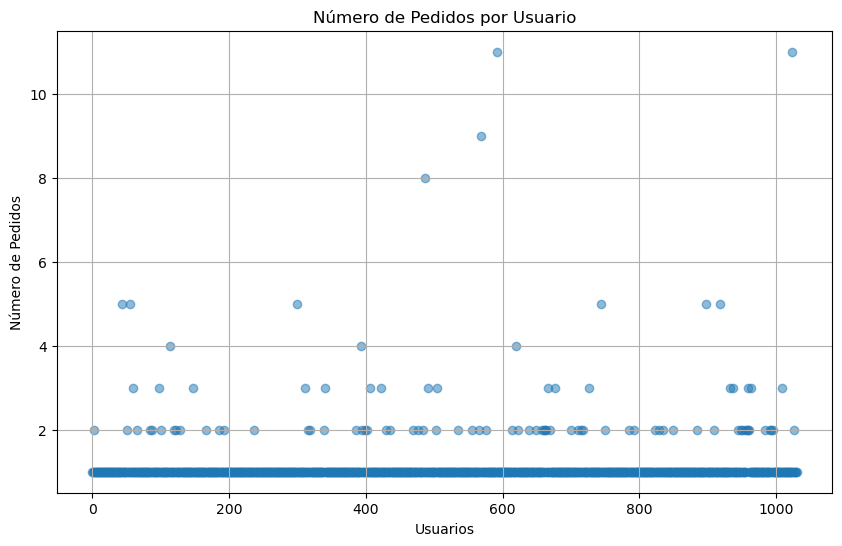

In [13]:
# Contar el número de pedidos por usuario
orders_per_user = ordenes.groupby("visitorId").agg({"transactionId": "count"}).reset_index()
orders_per_user.rename(columns={"transactionId": "orders"}, inplace=True)

# Graficar dispersión del número de pedidos por usuario
plt.figure(figsize=(10, 6))
plt.scatter(orders_per_user.index, orders_per_user["orders"], alpha=0.5)
plt.xlabel("Usuarios")
plt.ylabel("Número de Pedidos")
plt.title("Número de Pedidos por Usuario")
plt.grid(True)
plt.show()

In [14]:
# Calcular el número de pedidos por usuario
orders_per_user = ordenes.groupby("visitorId")["transactionId"].count()

# Calcular percentiles 95 y 99
percentile_95 = orders_per_user.quantile(0.95)
percentile_99 = orders_per_user.quantile(0.99)

# Definir umbral de anomalía (mayor al percentil 99)
anomaly_threshold_orders = percentile_99

percentile_95, percentile_99, anomaly_threshold_orders

(2.0, 4.0, 4.0)

Podemos notar que la mayoria de los usuarios hacen un pedido, lo que demuestra que puede haber una gran cantidad de usuarios nuevos, pero tambien que hay muy pocos retenidos. Eso o e promedio de conversion mensual es 1, lo que mostraria que se tiene una base de clientela solida

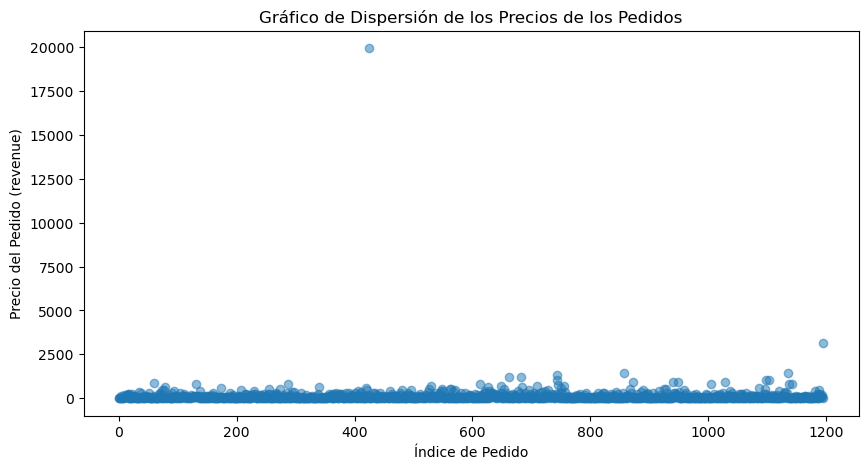

In [15]:
# Gráfico de dispersión de los precios de los pedidos
plt.figure(figsize=(10, 5))
plt.scatter(ordenes.index, ordenes["revenue"], alpha=0.5)
plt.xlabel("Índice de Pedido")
plt.ylabel("Precio del Pedido (revenue)")
plt.title("Gráfico de Dispersión de los Precios de los Pedidos")
plt.show()

In [16]:
# Calcular percentiles 95 y 99 de los precios de los pedidos
percentile_95_revenue = ordenes["revenue"].quantile(0.95)
percentile_99_revenue = ordenes["revenue"].quantile(0.99)

# Definir umbral de anomalía (mayor al percentil 99)
anomaly_threshold_revenue = percentile_99_revenue

percentile_95_revenue, percentile_99_revenue, anomaly_threshold_revenue

(435.54, 900.9039999999999, 900.9039999999999)

De la grafica y el calculo de los percentiles podemos notar que el precio de los pedidos son practicamente todos dentro del rango de 1000 lo que nos indica que a pesar del numero de pedidos, el precio se mantiene en un rango no muy alto

In [17]:
# Calcular conversiones
orders_per_group = ordenes.groupby("group")["visitorId"].nunique()
visits_per_group = visitas.groupby("group")["visits"].sum()

conversion_rates = orders_per_group / visits_per_group

# Prueba de significancia en la conversión
successes = orders_per_group.values
trials = visits_per_group.values

z_stat, p_value_conversion = proportions_ztest(successes, trials)

# Calcular el tamaño promedio de pedido por grupo
order_values_per_group = ordenes.groupby("group")["revenue"].mean()

# Prueba de significancia en el tamaño promedio de pedido
revenue_A = ordenes[ordenes["group"] == "A"]["revenue"]
revenue_B = ordenes[ordenes["group"] == "B"]["revenue"]

t_stat, p_value_order_size = ttest_ind(revenue_A, revenue_B, equal_var=False)

# Mostrar resultados
conversion_rates, (z_stat, p_value_conversion), order_values_per_group, (t_stat, p_value_order_size)

(group
 A    0.026847
 B    0.030979
 dtype: float64,
 (-2.392267236812302, 0.016744645350056243),
 group
 A    115.897487
 B    145.063438
 Name: revenue, dtype: float64,
 (-0.8886193336529402, 0.3745072295652421))

Dado que la conversión muestra una diferencia significativa a favor del grupo B, pero el tamaño promedio del pedido no, podríamos considerar detener la prueba y declarar al grupo B como líder. Sin embargo, si el tamaño del pedido es un factor crítico, podríamos optar por continuar la prueba para obtener más datos.

# Conclusiones

Junto con las graficas y los resultads de las pruebas estadisticas esta claro que el grupo B trae mayores ingresos. Sin embargo valdria la pena seguir revisando este comportamiento al igual que una investigacion mas profunda porque el grupo B tiene este comportamiento